In [1]:
!pip install datasets

In [2]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from matplotlib import pyplot as plt

# Load HF MNIST
ds = load_dataset("ylecun/mnist")

# Custom PyTorch Dataset
class MNISTDataset(Dataset):
    def __init__(self, hf_split):
        self.data = hf_split

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Convert PIL image to tensor (0–1)
        img = item["image"].convert("L")
        img = torch.tensor(np.array(img), dtype=torch.float32) / 255.0

        # Normalize to [-1, 1]
        img = img * 2 - 1

        # Add channel dimension: (1, H, W)
        img = img.unsqueeze(0)

        label = torch.tensor(item["label"], dtype=torch.long)
        return img, label

# Build datasets
train_dataset = MNISTDataset(ds["train"])
test_dataset  = MNISTDataset(ds["test"])

# Build dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
x, y = next(iter(train_loader))

In [4]:
from torch import nn
import torch as t

In [5]:
class Patch(nn.Module):
  def __init__(self, patch_size=4, in_channels=1, out_channels=32):
    super().__init__()
    self.out_channels = out_channels
    self.patch_size = patch_size
    self.conv = nn.Conv2d(in_channels, out_channels, 5, padding=2, stride=patch_size)

  def forward(self, x):
    """
    batch x c x h x w -> batch x (h//ps)*(w//ps) x d
    """
    b, c, h, w = x.shape
    x = self.conv(x)
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(b, h//self.patch_size * w//self.patch_size, self.out_channels)
    return x

class UnPatch(nn.Module):
  def __init__(self, patch_size=4, in_channels=32, out_channels=1):
    super().__init__()
    self.out_channels = out_channels
    self.patch_size = patch_size
    self.up = nn.Linear(in_channels, patch_size**2 * out_channels)

  def forward(self, x):
    """
     batch x (h//ps)*(w//ps) x d -> batch x c x h x w
    """
    b, s, d = x.shape
    x = self.up(x)
    w = int(s**0.5)
    h = w
    x = x.reshape(b, h, w, self.out_channels, self.patch_size, self.patch_size)
    x = x.permute(0, 3, 1, 4, 2, 5)
    x = x.reshape(b, self.out_channels, h*self.patch_size, w*self.patch_size)
    return x


patch = Patch()
unpatch = UnPatch()
print(x.shape)
print(patch(x).shape)
print(unpatch(patch(x)).shape)


torch.Size([64, 1, 28, 28])
torch.Size([64, 49, 32])
torch.Size([64, 1, 28, 28])


In [6]:
class RMSNorm(nn.Module):
  def __init__(self, d=32, eps=1e-6):
    super().__init__()
    self.scale = nn.Parameter(t.ones((1,1,d)))
    self.eps = eps

  def forward(self, x):
    x = x/(((x**2).mean())**0.5 + self.eps)
    x = x * self.scale
    return x

norm = RMSNorm()
print(norm(patch(x)).shape)



torch.Size([64, 49, 32])


In [7]:
class MLP(nn.Module):
  def __init__(self, d=32, exp=2):
    super().__init__()
    self.d = d
    self.exp = exp
    self.up = nn.Linear(d, exp*d, bias=False)
    self.gate = nn.Linear(d, exp*d, bias=False)
    self.down = nn.Linear(exp*d, d, bias=False)
    self.act = nn.SiLU()

  def forward(self, x):
    x = self.up(x) * self.act(self.gate(x))
    x = self.down(x)
    return x

mlp = MLP()
print(mlp(patch(x)).shape)

torch.Size([64, 49, 32])


In [8]:
class Attention(nn.Module):
  def __init__(self, d=32, n_head=4):
    super().__init__()
    self.n_head = n_head
    self.d = d
    self.d_head = d//n_head
    self.QKV = nn.Linear(d, 3*d, bias=False)
    self.O = nn.Linear(d, d, bias=False)
    self.normq = RMSNorm(self.d_head)
    self.normk = RMSNorm(self.d_head)

  def forward(self, x):
    b, s, d = x.shape
    q, k, v = self.QKV(x).chunk(3, dim=-1)
    q = q.reshape(b, s, self.n_head, self.d_head)
    k = k.reshape(b, s, self.n_head, self.d_head)
    v = v.reshape(b, s, self.n_head, self.d_head)
    q = self.normq(q)
    k = self.normk(k)
    attn = q.permute(0, 2, 1, 3) @ k.permute(0, 2, 3, 1)
    attn = attn.softmax(dim=-1)
    # b, nh, sq, sk
    z = attn @ v.permute(0, 2, 1, 3)
    # b, nh, sq, dh
    z = z.permute(0, 2, 1, 3)
    z = z.reshape(b, s, self.d)
    z = self.O(z)
    return z

attn = Attention()
print(attn(patch(x)).shape)


torch.Size([64, 49, 32])


torch.Size([16, 32])


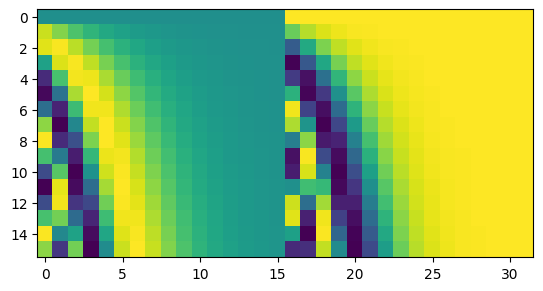

In [9]:
class NumEmbedding(nn.Module):
  def __init__(self, n_max, d=32, C=500):
    super().__init__()
    thetas = C**(-t.arange(0, d//2)/(d//2))
    thetas = t.arange(0, n_max)[:, None].float() @ thetas[None, :]
    sins = t.sin(thetas)
    coss = t.cos(thetas)
    self.register_buffer("E", t.cat([sins, coss], dim=1))

  def forward(self, x):
    return self.E[x]


ne = NumEmbedding(16)
out = ne(t.arange(16))
print(out.shape)
plt.imshow(out.detach().cpu())
plt.show()


In [10]:
class DiTBlock(nn.Module):
  def __init__(self, d=32, n_head=4, exp=2):
    super().__init__()
    self.d = d
    self.n_head = n_head
    self.exp = exp
    self.norm1 = RMSNorm(d)
    self.attn = Attention(d, n_head)
    self.norm2 = RMSNorm(d)
    self.mlp = MLP(d)
    self.modulate = nn.Linear(d, 6*d)

  def forward(self, x, c):
    """
    x ... b, s, d
    c ... b, d
    """
    scale1, bias1, gate1, scale2, bias2, gate2 = self.modulate(c).chunk(6, dim=-1)
    residual = x
    x = self.norm1(x) * scale1[:, None, :] + bias1[:, None, :]
    x = self.attn(x) * gate1[:, None, :]
    x = residual + x

    residual = x
    x = self.norm2(x) * scale2[:, None, :] + bias2[:, None, :]
    x = self.mlp(x) * gate2[:, None, :]
    x = residual + x
    return x

block = DiTBlock()
emb = nn.Embedding(10, 32)
print(block(patch(x), emb(y)).shape)


torch.Size([64, 49, 32])


In [11]:
class DiT(nn.Module):
  def __init__(self, h, w, n_classes=10, in_channels=1, patch_size=4, n_blocks=4, d=32, n_head=4, exp=2, T=1000):
    super().__init__()
    self.T = T
    self.patch = Patch(patch_size, in_channels, d)
    self.n_seq = h//patch_size * w//patch_size
    self.pe = nn.Parameter(t.randn(1, self.n_seq, d)*d**(-0.5))
    self.te = NumEmbedding(T, d)
    self.ce = nn.Embedding(n_classes, d)
    self.act = nn.SiLU()
    self.blocks = nn.ModuleList([DiTBlock(d, n_head, exp) for _ in range(n_blocks)])
    self.norm = RMSNorm(d)
    self.modulate = nn.Linear(d, 2*d)
    self.unpatch = UnPatch(patch_size, d, in_channels)

  def forward(self, x, c, ts):
    """
    x ... b, c, h, w
    c ... b
    ts ... b
    """
    ts_int = t.minimum((ts * self.T).to(t.int64), t.tensor(self.T-1))
    cond = self.act(self.te(ts_int) + self.ce(c)) # b x d
    x = self.patch(x) + self.pe
    for idx, block in enumerate(self.blocks):
      x = block(x, cond)
    scale, bias = self.modulate(cond).chunk(2, dim=-1)
    x = self.norm(x) * scale[:, None, :] + bias[:, None, :]
    x = self.unpatch(x)
    return x

from torch.optim import AdamW

model = DiT(28, 28, patch_size=2, n_classes=11, d=12*16, n_head=12, n_blocks=6)
opt = AdamW(model.parameters(), lr=1e-3, betas=(0.9, 0.95))
model.cuda()


DiT(
  (patch): Patch(
    (conv): Conv2d(1, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  )
  (te): NumEmbedding()
  (ce): Embedding(11, 192)
  (act): SiLU()
  (blocks): ModuleList(
    (0-5): 6 x DiTBlock(
      (norm1): RMSNorm()
      (attn): Attention(
        (QKV): Linear(in_features=192, out_features=576, bias=False)
        (O): Linear(in_features=192, out_features=192, bias=False)
        (normq): RMSNorm()
        (normk): RMSNorm()
      )
      (norm2): RMSNorm()
      (mlp): MLP(
        (up): Linear(in_features=192, out_features=384, bias=False)
        (gate): Linear(in_features=192, out_features=384, bias=False)
        (down): Linear(in_features=384, out_features=192, bias=False)
        (act): SiLU()
      )
      (modulate): Linear(in_features=192, out_features=1152, bias=True)
    )
  )
  (norm): RMSNorm()
  (modulate): Linear(in_features=192, out_features=384, bias=True)
  (unpatch): UnPatch(
    (up): Linear(in_features=192, out_features=4, bias=True)

In [12]:
from tqdm import tqdm

for _ in range(10):
  pbar = tqdm(train_loader)
  for x, y in pbar:
    x = x.cuda()
    y = y.cuda()+1
    y[t.rand(y.shape[0]) < 0.2] = 0

    ts = nn.functional.sigmoid(t.randn(x.shape[0], device=x.device, dtype=x.dtype))
    z = t.randn_like(x, dtype=x.dtype, device=x.device)
    v_true = x - z
    x_t = x - ts[:, None, None, None]*v_true
    v_pred = model(x_t, y, ts)
    loss = nn.functional.mse_loss(v_pred, v_true)

    loss.backward()
    t.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
    pbar.set_postfix(loss=loss.item())
    opt.step()
    opt.zero_grad()


100%|██████████| 938/938 [03:09<00:00,  4.96it/s, loss=0.154]


In [13]:
@t.no_grad()
def sample(model, z, y, n_steps=10, cfg=0):
  ts = t.linspace(1, 0, n_steps+1, device=z.device, dtype=z.dtype)
  ts = 3*ts / (2*ts+1) # sd3 scheduler
  for idx in range(n_steps):
    v_pred = model(z, y, ts[idx]*t.ones(z.shape[0], dtype=z.dtype, device=z.device))
    if cfg > 0:
      v_uncond = model(z, y*0, ts[idx]*t.ones(z.shape[0], dtype=z.dtype, device=z.device))
      v_pred = v_uncond + cfg*(v_pred - v_uncond)
    z = z + (ts[idx]-ts[idx+1])*v_pred
  return z

0


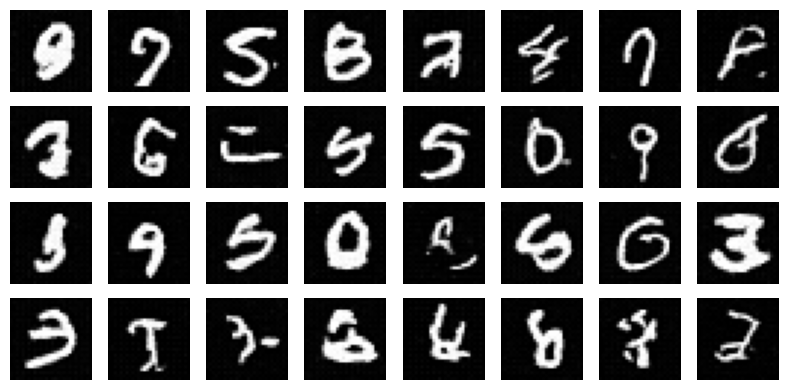

1


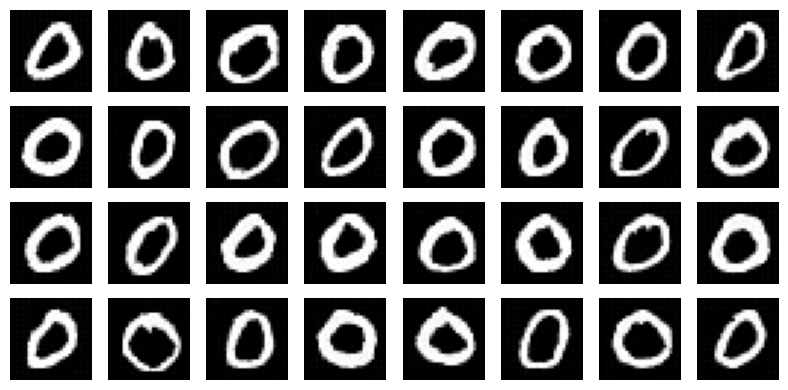

2


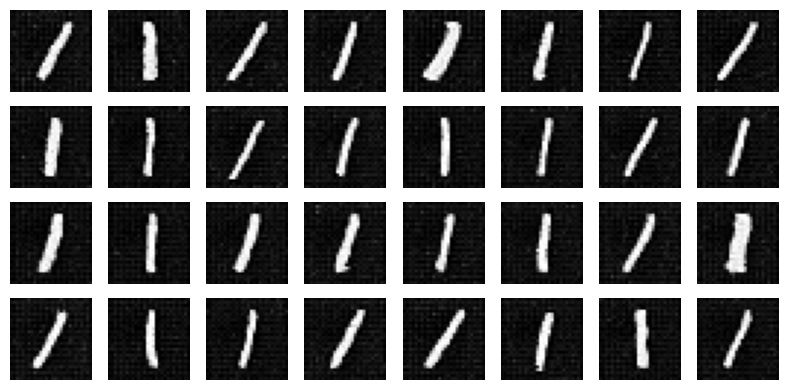

3


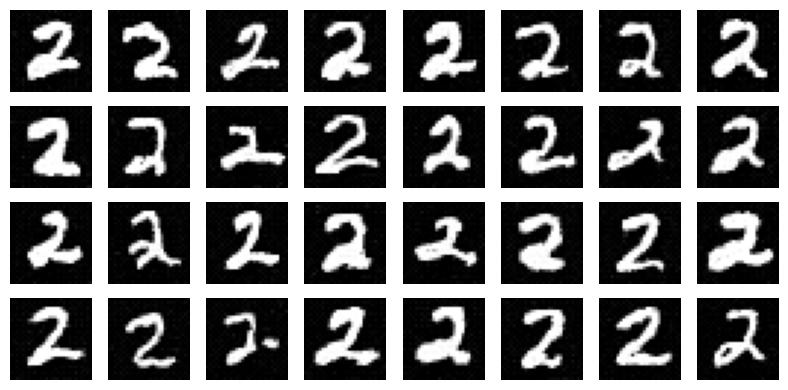

4


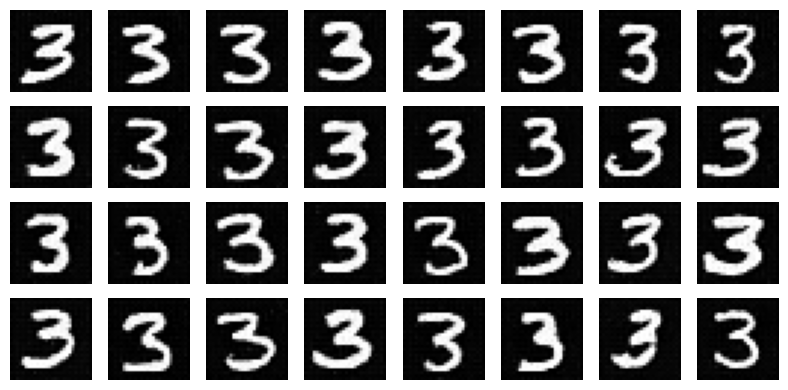

5


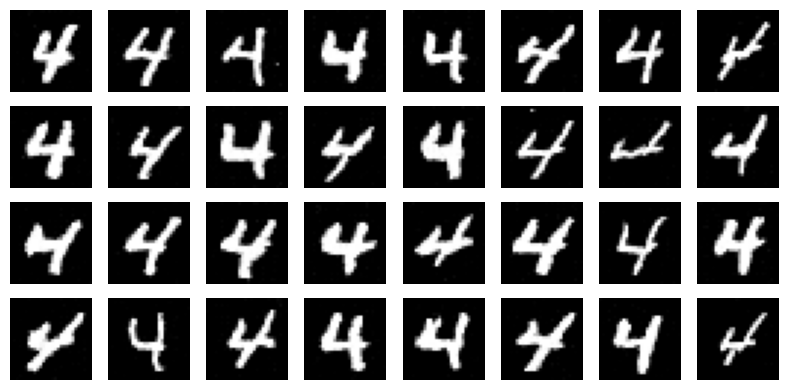

6


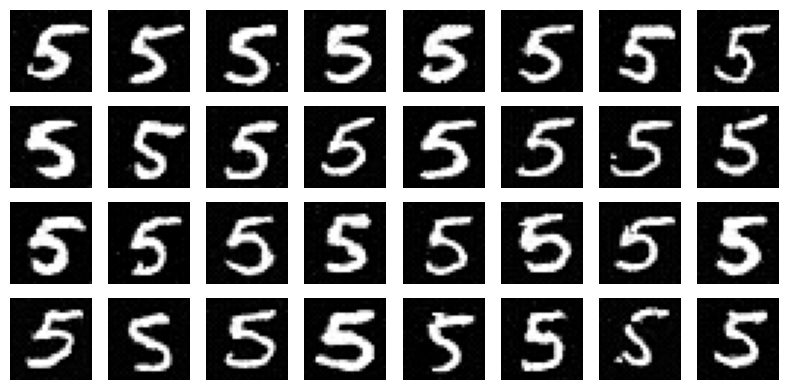

7


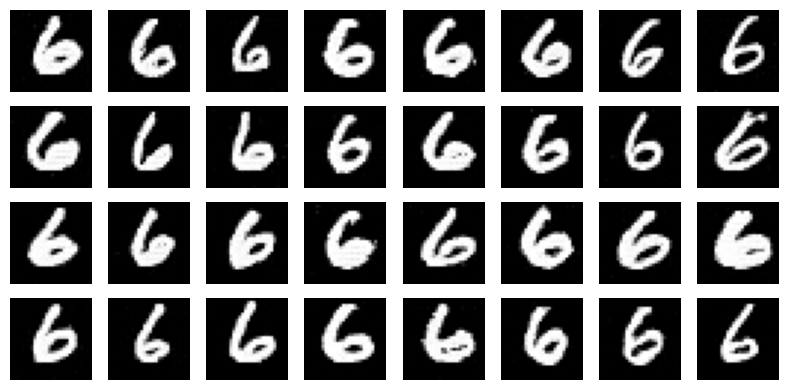

8


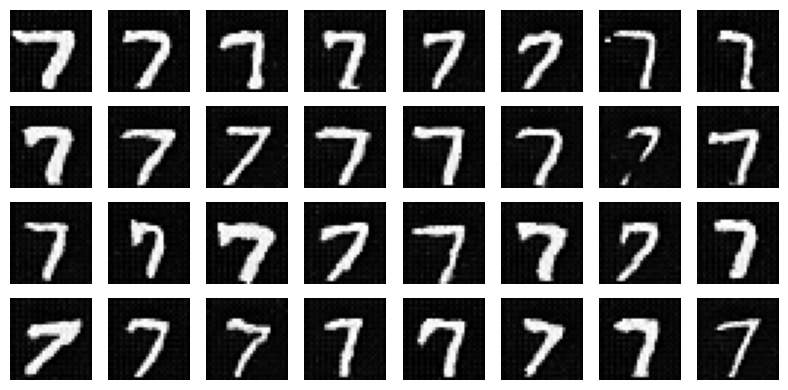

9


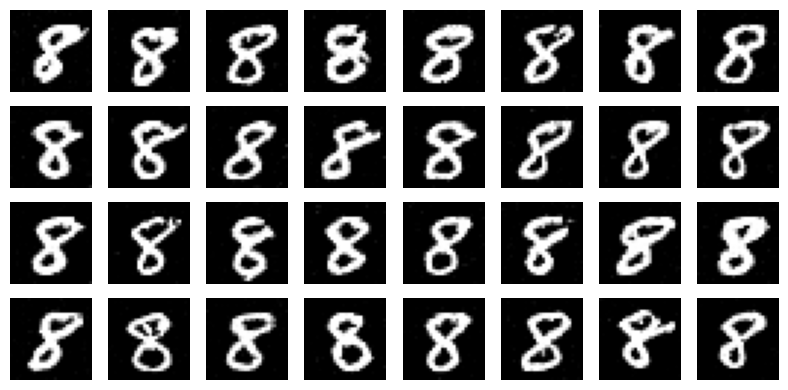

10


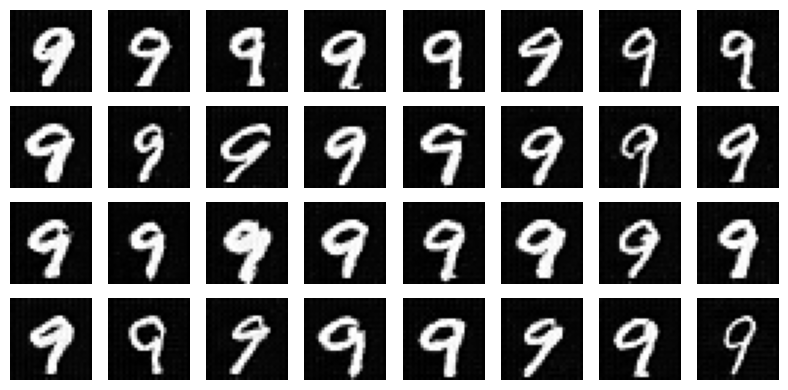

In [14]:
z = t.randn_like(x, dtype=x.dtype, device=x.device)
for num in range(11):
  print(num)
  if num > 0:
    cfg = 3
  else:
    cfg = 0
  x_pred = sample(model, z, y*0 + num, cfg=cfg, n_steps=30)
  import matplotlib.pyplot as plt

  fig, axes = plt.subplots(4, 8, figsize=(8, 4))
  axes = axes.flatten()

  for i in range(32):
      img = x_pred[i].squeeze().detach().cpu().clamp(-1, 1)
      img = (img + 1) / 2  # map back to [0,1]

      axes[i].imshow(img, cmap='gray')
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()



0


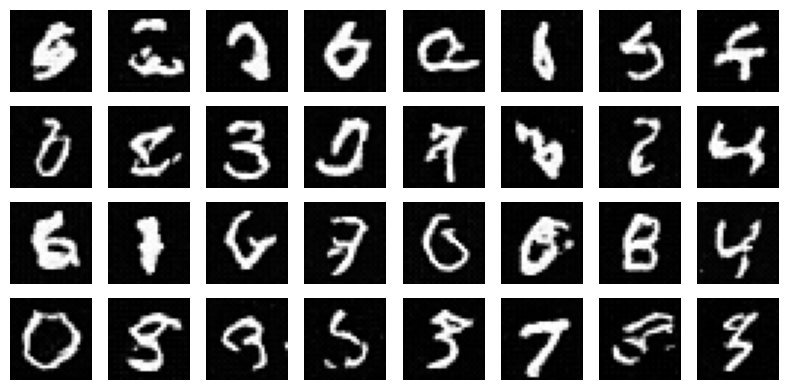

1


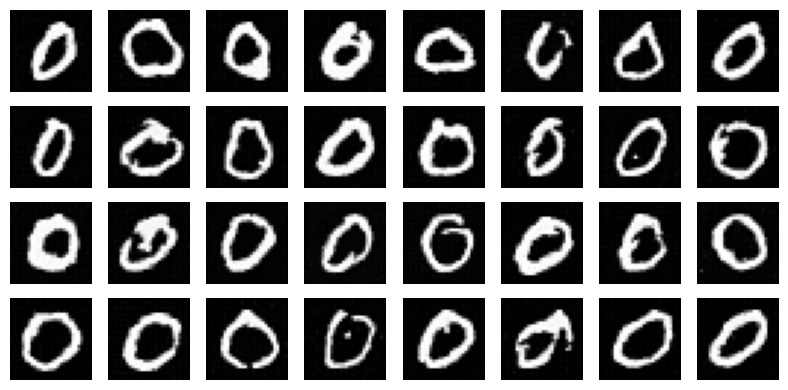

2


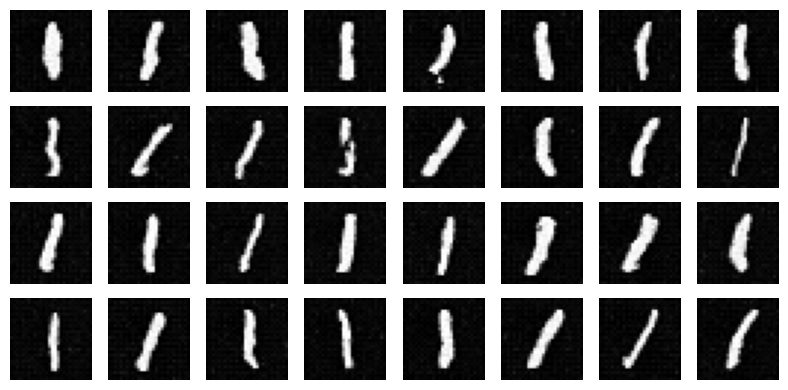

3


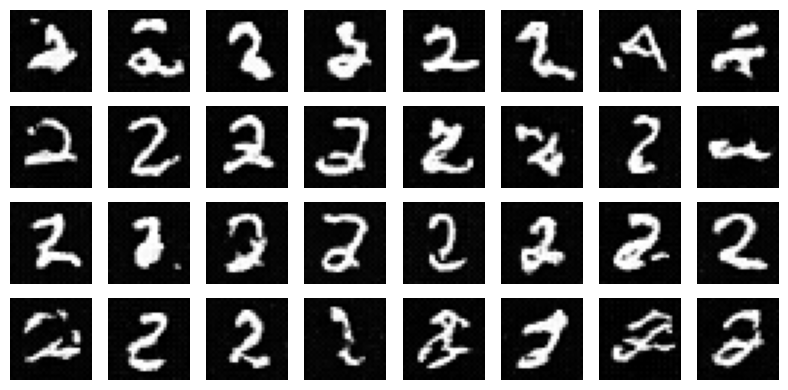

4


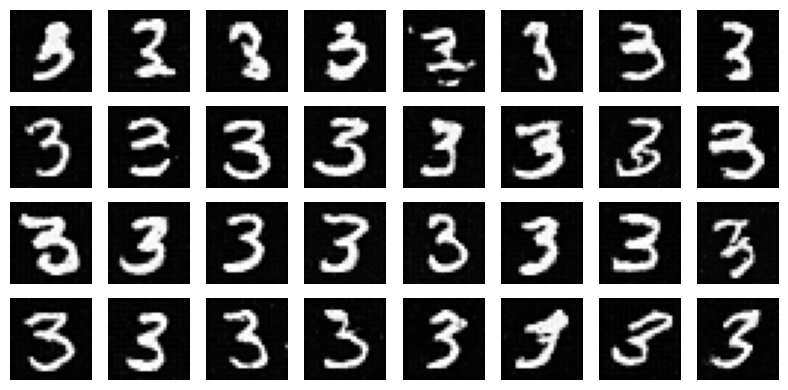

5


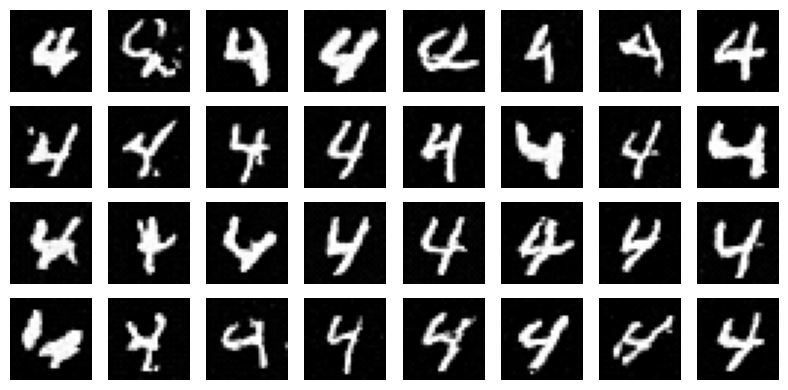

6


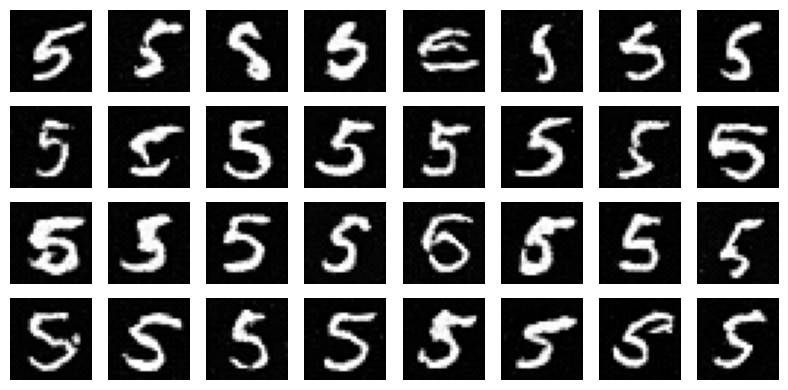

7


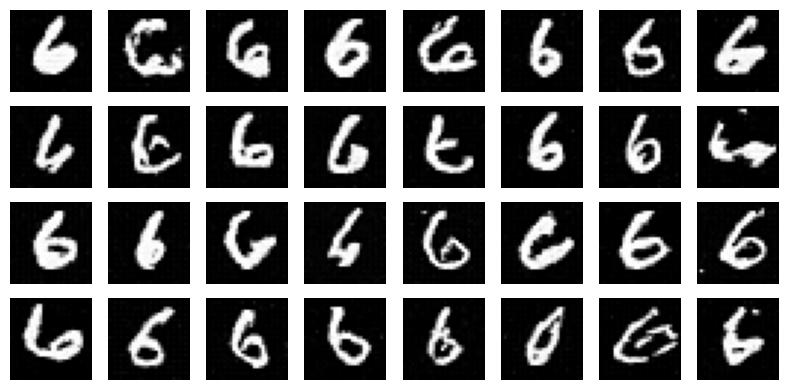

8


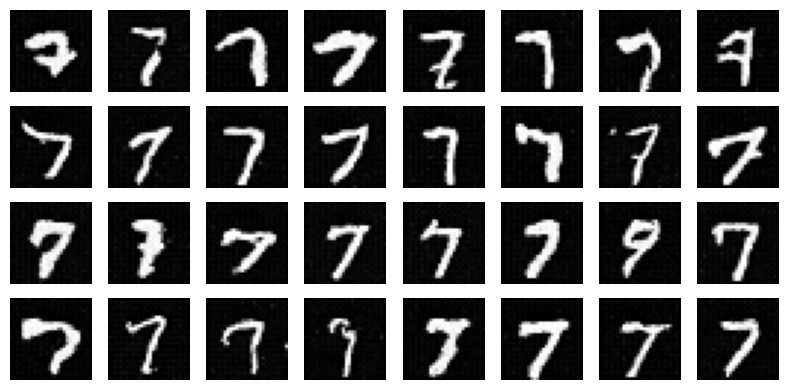

9


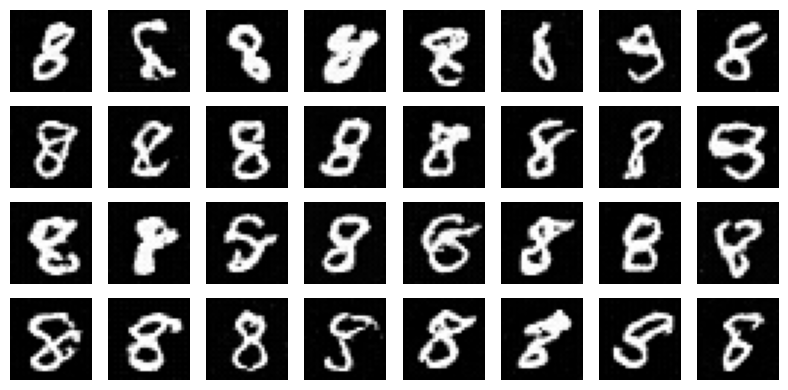

10


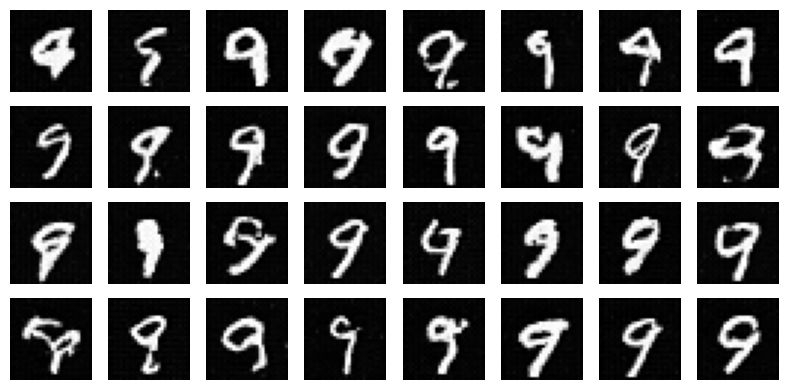

In [15]:
z = t.randn_like(x, dtype=x.dtype, device=x.device)
for num in range(11):
  print(num)
  if num > 0:
    cfg = 0
  else:
    cfg = 0
  x_pred = sample(model, z, y*0 + num, cfg=cfg, n_steps=30)
  import matplotlib.pyplot as plt

  fig, axes = plt.subplots(4, 8, figsize=(8, 4))
  axes = axes.flatten()

  for i in range(32):
      img = x_pred[i].squeeze().detach().cpu().clamp(-1, 1)
      img = (img + 1) / 2  # map back to [0,1]

      axes[i].imshow(img, cmap='gray')
      axes[i].axis('off')

  plt.tight_layout()
  plt.show()

